# Tutorial 3 Car Purchase
In this tutorial, we will build machine learning models to help a car retail company to "learn" their customer behaviour. 
They have collected some data on their previous customers and listed in "Car_Advertisement.csv". In the datasheet, you can see 5 columns:
+ User ID (instead of names, the company is using an ID to protect their privacy!)
+ Gender 
+ Age
+ Salary
+ Purchased (whether or not they purchased a car - this is the target for our predictions)
Using these data, the company want to be build a ML model that can predict if a new customer will purchase a car based on their gender, age and salary.

## 1. Importing Basic Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. Importing the Data

In [5]:
data = pd.read_csv('../data/CarAdvertisement.csv')

## 3. Converting the Catogorical Data to Numerical Data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   UserID           400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    object
dtypes: int64(3), object(2)
memory usage: 15.8+ KB


In [7]:
purchases = {'Not Purchased': 0, 'Purchased': 1}
data['Purchased'] = data['Purchased'].map(purchases)
pd.DataFrame(data['Purchased'])

,Purchased
0,0
1,0
2,0
3,0
4,0
...,...
395,1
396,1
397,1
398,0


In [8]:
genders = {'Male': 0, 'Female': 1}
data['Gender'] = data['Gender'].map(genders)
pd.DataFrame(data['Gender'])

,Gender
0,0
1,0
2,1
3,1
4,0
...,...
395,1
396,0
397,1
398,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   UserID           400 non-null    int64
 1   Gender           400 non-null    int64
 2   Age              400 non-null    int64
 3   EstimatedSalary  400 non-null    int64
 4   Purchased        400 non-null    int64
dtypes: int64(5)
memory usage: 15.8 KB


## 4. Exploring the Data
#### Checking the correlations between the output parameter 'Purchased' and input features

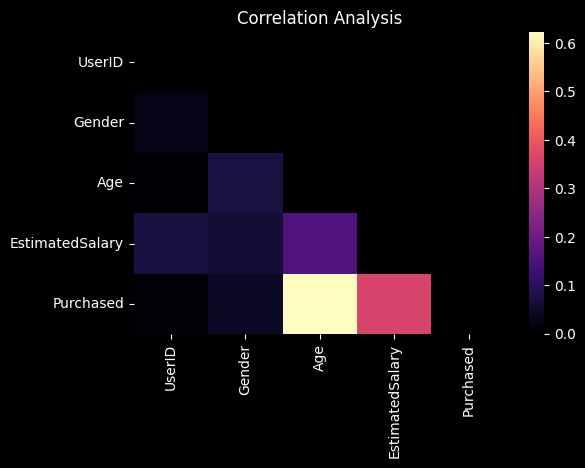

Purchased          1.000000
Age                0.622454
EstimatedSalary    0.362083
Gender             0.042469
UserID             0.007120
Name: Purchased, dtype: float64

In [24]:
plt.style.use('dark_background')

corr_matrix = data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Only keep the upper triangle of an array.
from seaborn import heatmap

plt.figure(dpi=100)
plt.title('Correlation Analysis')
heatmap(corr_matrix, mask=mask, annot=False, lw=0, linecolor='white', cmap='magma', fmt="0.2f")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

corr_matrix["Purchased"].sort_values(ascending=False)

Due to the low correlations, we will drop the UserID and Gender parameters later before training.

## 4. Splitting the Test and Train Data

In [11]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2)

Y_train = train_data[['Purchased']].copy()
X_train = train_data.drop(['Purchased', 'UserID', 'Gender'],
                          axis=1)  # We drop the 'UserID', 'Gender', and 'Purchased' parameters from the features

X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()
Y_train = Y_train.ravel()

## 5. Visualizing the Data

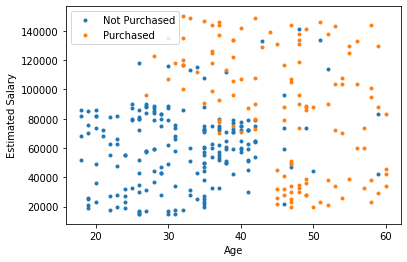

In [12]:
def plot_scatter_with_labels(X1, X2, Y, xlabel='Age', ylabel='Estimated Salary'):
    df = pd.DataFrame(dict(x1=X1, x2=X2, label=Y))
    groups = df.groupby('label')
    for number, group in groups:
        if number == 0:
            name = 'Not Purchased'
        elif number == 1:
            name = 'Purchased'
        plt.plot(group.x1, group.x2,
                 marker="o", linestyle="", ms=3, label=name)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


plot_scatter_with_labels(train_data['Age'],
                         train_data['EstimatedSalary'],
                         train_data['Purchased'])

## 6. Scaling the Features
We standardize all the data using their mean and standard deviation

$$ \hat{x_i} = \frac{x_i-\mu}{\sigma_i}$$

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print(type(X_train), X_train.shape)

<class 'numpy.ndarray'> (320, 2)


## 7. Exploring Different Machine Learning Models

### 7.1. Discriminant Analysis Classifier

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

da_clf = LinearDiscriminantAnalysis()
da_clf.fit(X_train, Y_train)

LinearDiscriminantAnalysis()

#### Cross validation

In [25]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(da_clf, X_train, Y_train, scoring='accuracy', cv=5)  # 5-fold
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores = {}
avg_cv_scores['DA'] = np.average(scores)

[0.84375  0.859375 0.828125 0.84375  0.859375]
Averaged prediction accuracy =  0.846875


#### Visualization
Decision boundary shows how a fited model predicts labels across the input feature space

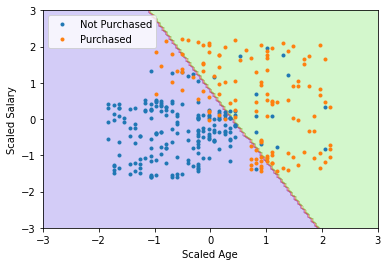

In [16]:
def plot_decision_boundary(clf, axes, inverse_transform=False):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(100, 100)
    if inverse_transform:
        X = scaler.inverse_transform(np.c_[x0s, x1s])
        x0, x1 = np.meshgrid(X[:, 0], X[:, 1])
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)


def plot_prediction_results(clf, X, Y):
    plot_decision_boundary(clf, [-3, 3, -3, 3])
    plot_scatter_with_labels(X[:, 0], X[:, 1], Y, xlabel='Scaled Age', ylabel='Scaled Salary')


plot_prediction_results(da_clf, X_train, Y_train)

### 7.2. Naive Bayes Classifier 

[0.890625 0.859375 0.875    0.90625  0.875   ]
Averaged prediction accuracy =  0.88125


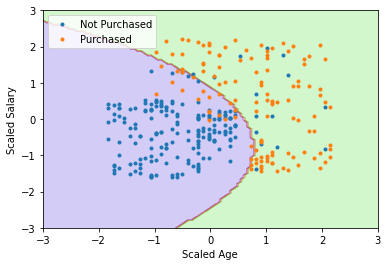

In [17]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
nb_clf.fit(X_train, Y_train)
scores = cross_val_score(nb_clf, X_train, Y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['NB'] = np.average(scores)
plot_prediction_results(nb_clf, X_train, Y_train)

### 7.3. K-Nearst Neighbors

[0.890625 0.875    0.875    0.90625  0.890625]
Averaged prediction accuracy =  0.8875


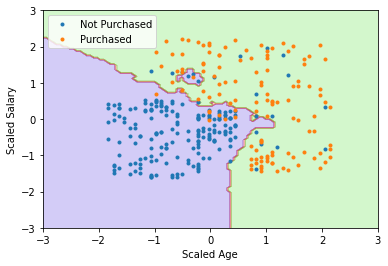

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(
    n_neighbors=5)  # change n_neighbors; boundary becomes smoother with increasing value of K
knn_clf.fit(X_train, Y_train)
scores = cross_val_score(knn_clf, X_train, Y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['KNN'] = np.average(scores)
plot_prediction_results(knn_clf, X_train, Y_train)

### 7.4. Linear SVM

[0.828125 0.8125   0.828125 0.8125   0.828125]
Averaged prediction accuracy =  0.821875


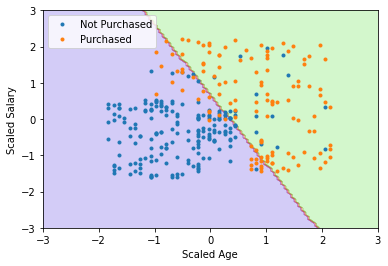

In [19]:
from sklearn.svm import SVC

svmln_clf = SVC(kernel='linear')
svmln_clf.fit(X_train, Y_train)
scores = cross_val_score(svmln_clf, X_train, Y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['SVM-linear'] = np.average(scores)
plot_prediction_results(svmln_clf, X_train, Y_train)

### 7.5. Nonlinear SVM (Gaussian Kernel)

[0.921875 0.859375 0.890625 0.9375   0.890625]
Averaged prediction accuracy =  0.9


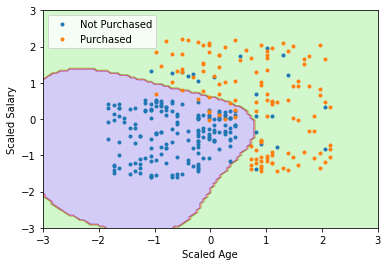

In [20]:
from sklearn.svm import SVC

svmrbf_clf = SVC(kernel='rbf')
svmrbf_clf.fit(X_train, Y_train)
scores = cross_val_score(svmrbf_clf, X_train, Y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['SVM-nonlinear'] = np.average(scores)
plot_prediction_results(svmrbf_clf, X_train, Y_train)

### 7.6. Decision Tree

[0.890625 0.890625 0.890625 0.90625  0.875   ]
Averaged prediction accuracy =  0.890625


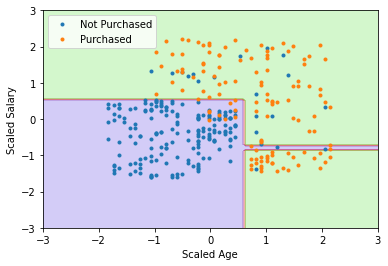

In [21]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=3)  # Play with hyperparameter
tree_clf.fit(X_train, Y_train)
scores = cross_val_score(tree_clf, X_train, Y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['Decision Tree'] = np.average(scores)
plot_prediction_results(tree_clf, X_train, Y_train)

### 7.7. Comparing and Selecting the Models

In [22]:
print(avg_cv_scores)

{'DA': 0.846875, 'NB': 0.88125, 'KNN': 0.8875, 'SVM-linear': 0.821875, 'SVM-nonlinear': 0.9, 'Decision Tree': 0.890625}


In [23]:
X_test = scaler.transform(test_data[["Age", "EstimatedSalary"]])
Y_test_pred = svmrbf_clf.predict(X_test)
accuracy = np.sum(Y_test_pred == test_data["Purchased"]) / len(Y_test_pred)
print("Accuracy on test set: ", accuracy)

Accuracy on test set:  0.9375


/home/liamb/Repositories/school/Manu465/.venv/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
